# Simulate dropout smearing

Try to simulate a complex function f: R->R. Let a model train on it. Then shift the function up and use dropout. How good will it adapt? Will there be smearing?

In [10]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [25]:
x = np.linspace(0,10,200, dtype=np.float32)
x

array([ 0.        ,  0.05025126,  0.10050251,  0.15075377,  0.20100503,
        0.2512563 ,  0.30150753,  0.3517588 ,  0.40201005,  0.4522613 ,
        0.5025126 ,  0.5527638 ,  0.60301507,  0.6532663 ,  0.7035176 ,
        0.75376886,  0.8040201 ,  0.85427135,  0.9045226 ,  0.95477384,
        1.0050251 ,  1.0552764 ,  1.1055276 ,  1.1557789 ,  1.2060301 ,
        1.2562814 ,  1.3065326 ,  1.3567839 ,  1.4070352 ,  1.4572865 ,
        1.5075377 ,  1.557789  ,  1.6080402 ,  1.6582915 ,  1.7085427 ,
        1.758794  ,  1.8090452 ,  1.8592964 ,  1.9095477 ,  1.959799  ,
        2.0100503 ,  2.0603015 ,  2.1105528 ,  2.160804  ,  2.2110553 ,
        2.2613065 ,  2.3115578 ,  2.361809  ,  2.4120603 ,  2.4623115 ,
        2.5125628 ,  2.562814  ,  2.6130652 ,  2.6633165 ,  2.7135677 ,
        2.763819  ,  2.8140705 ,  2.8643217 ,  2.914573  ,  2.9648242 ,
        3.0150754 ,  3.0653267 ,  3.115578  ,  3.1658292 ,  3.2160804 ,
        3.2663317 ,  3.316583  ,  3.3668342 ,  3.4170854 ,  3.46

In [26]:
f = lambda x: np.sin(x) + np.sin(x/7) + np.sin(x/5) - np.sin(x/3) + np.sin(9*x) * np.exp(-x ** 2) + 1.5 + np.random.normal(0,2e-2,x.shape)
y = f(x)


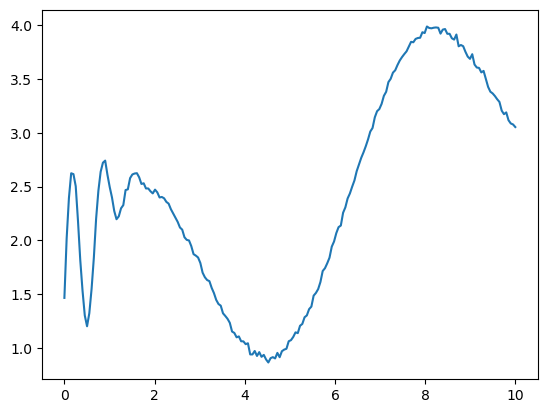

In [27]:
plt.plot(x,y)

In [28]:
from torch import nn
import torch

class LinearNet(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.do = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc3(x)
        return x

In [29]:
from torch.utils.data import DataLoader,TensorDataset

train_mask = np.zeros([x.shape[0]],dtype=bool)
train_mask[:int(0.6*x.shape[0])] = 1
np.random.shuffle(train_mask)
test_mask = ~train_mask


train_set = TensorDataset(torch.from_numpy(x[train_mask]), torch.from_numpy(y[train_mask]))
train_loader = DataLoader(train_set, batch_size=16, shuffle=False)

test_set = TensorDataset(torch.from_numpy(x[test_mask]), torch.from_numpy(y[test_mask]))
test_dataloader= DataLoader(test_set, batch_size=16, shuffle=False)


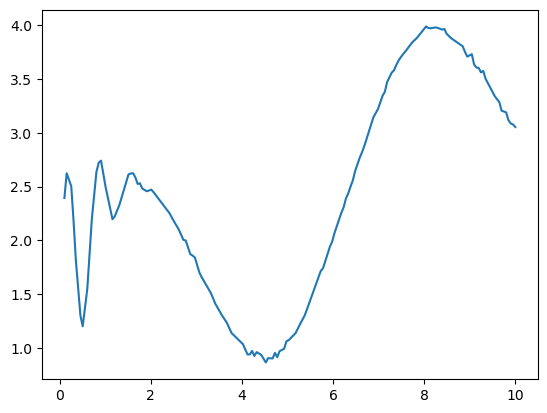

In [30]:
plt.plot(x[train_mask],y[train_mask])

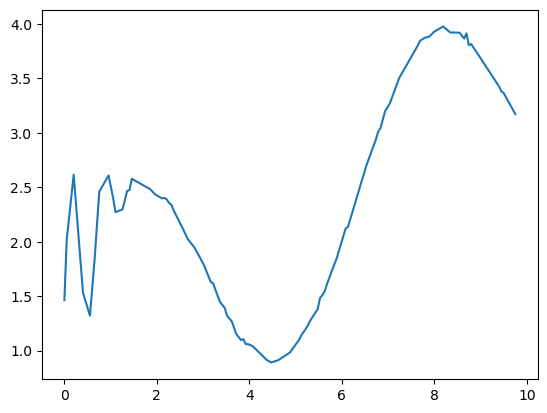

In [31]:
plt.plot(x[test_mask],y[test_mask])

In [32]:
dataloaders = {'train':train_loader,
               'eval':test_dataloader}

In [34]:
import time
class early_stopping_callback:
  def __init__(self,min_delta=0,patience=1):
    self.min_delta=min_delta
    self.patience=patience
    self.counter=0
    self.lowest_loss=np.inf
  def check_early_stopping(self,eval_loss):
    delta =  self.lowest_loss - eval_loss
    if delta >= self.min_delta:
      self.lowest_loss = eval_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False
  


    
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5, verbose = 0):
    since = time.time()
    if verbose > 0:
      modulo_coeff = 10
    else:
      modulo_coeff = 100

    patience = 10
    es_callback = early_stopping_callback(min_delta=0,patience=patience)

    val_acc_history = []
    for epoch in range(num_epochs):
        if epoch % modulo_coeff == 0:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        ############ train phase ############
        phase = 'train'
        model.train()

        running_loss = 0.0
        # running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          optimizer.zero_grad()
          outputs = model(inputs.unsqueeze(1))
          loss = loss_fn(outputs, labels.unsqueeze(1).float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        ############ eval phase ############
        phase = 'eval'
        model.eval()

        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs.unsqueeze(1))
            loss = loss_fn(outputs, labels.unsqueeze(1).float())

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if es_callback.check_early_stopping(epoch_loss):
          print(f"Stopping early after epoch {epoch}")
          break

        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))  

        val_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 0m 19s
Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 0m 21s
Epoch 0/

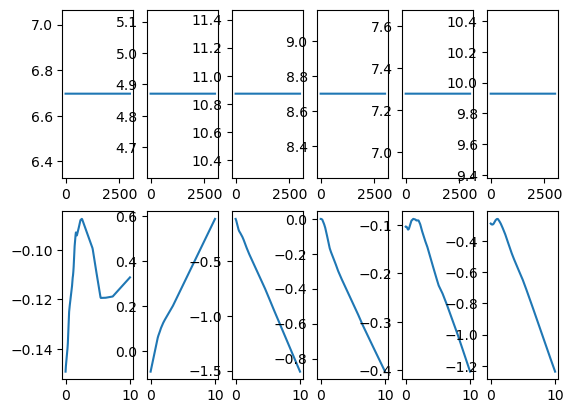

In [35]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
loss_fn = nn.MSELoss()
dropout_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]

fig, axs = plt.subplots(2, len(dropout_list))

for idx, dropout_prob in enumerate(dropout_list):
    optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)
    model = LinearNet(dropout_prob)
    hist = train_model(model,
                    dataloaders,
                    loss_fn,
                    optimizer,
                    num_epochs=3000
                    )

    axs[0,idx].plot(hist)
    axs[1,idx].plot(x,model(torch.from_numpy(x).unsqueeze(1)).detach().numpy())

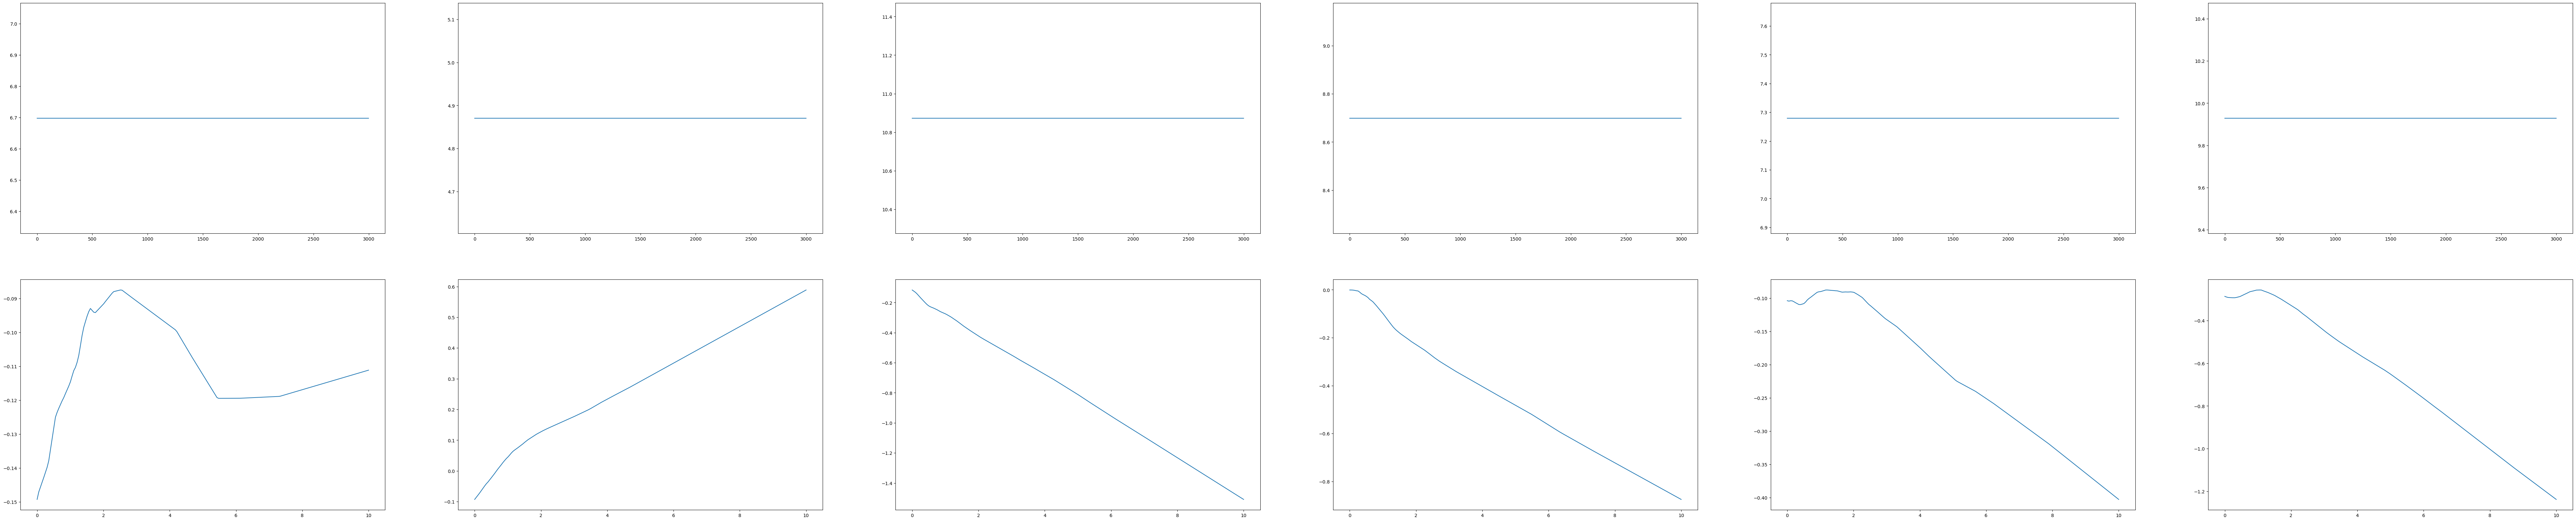

In [39]:
fig.set_size_inches(100, 20)
fig

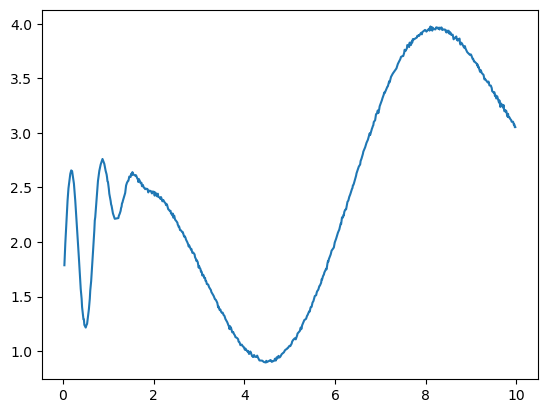

In [ ]:
plt.plot(x[train_mask],y[train_mask])

# Test with data

In [1]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
)
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from torch import nn
import torch

In [2]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
task_name = "rte"
raw_datasets = load_dataset("glue", task_name)
label_list = raw_datasets["train"].features["label"].names
num_labels = len(label_list)
is_regression = False

model_name_or_path = "bert-base-cased"

config = AutoConfig.from_pretrained(model_name_or_path, num_labels=num_labels, finetuning_task=task_name)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
    ignore_mismatched_sizes=False,
    )

Found cached dataset glue (C:/Users/Valentin/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [3]:
model.config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [4]:
PretrainedConfig(num_labels=num_labels).label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [5]:
# Preprocessing the datasets
sentence1_key, sentence2_key = task_to_keys[task_name]


# Some models have set the order of the labels to use, so let's make sure we do use it.
label_to_id = None
if (
    model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
    and task_name is not None
):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: label_name_to_id[label_list[i]] for i in range(num_labels)}
elif task_name is None:
    label_to_id = {v: i for i, v in enumerate(label_list)}

if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}
elif task_name is not None and not is_regression:
    model.config.label2id = {l: i for i, l in enumerate(label_list)}
    model.config.id2label = {id: label for label, id in config.label2id.items()}

padding = False
max_length = 128

def preprocess_function(examples):
    # Tokenize the texts
    texts = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*texts, padding=padding, max_length=max_length, truncation=True)

    if "label" in examples:
        if label_to_id is not None:
            # Map labels to IDs (not necessary for GLUE tasks)
            result["labels"] = [label_to_id[l] for l in examples["label"]]
        else:
            # In all cases, rename the column to labels because the model will expect that.
            result["labels"] = examples["label"]
    return result

processed_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation_matched" if task_name == "mnli" else "validation"]
data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=None)
batch_size = 3

train_dataloader = DataLoader(
        train_dataset, shuffle=True, collate_fn=data_collator, batch_size=batch_size
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=batch_size)


Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\rte\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-1f10d1f2f53e0be4.arrow
Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\rte\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-a63622d1e29c267b.arrow
Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\rte\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-85bb0cd57dac3d6c.arrow


In [6]:
raw_datasets['validation'][0]

{'sentence1': 'Dana Reeve, the widow of the actor Christopher Reeve, has died of lung cancer at age 44, according to the Christopher Reeve Foundation.',
 'sentence2': 'Christopher Reeve had an accident.',
 'label': 1,
 'idx': 0}

In [7]:
for batch in eval_dataloader:
    print(model(**batch))
    break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


SequenceClassifierOutput(loss=tensor(0.6399, grad_fn=<NllLossBackward0>), logits=tensor([[0.1436, 0.6108],
        [0.1570, 0.6002],
        [0.1605, 0.6083]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [12]:
import evaluate

eval_loss = 0
predicted_logits = torch.empty(0,2)
predicted_probabilites = torch.empty(0,2)
predictions = torch.empty(0)
softmax_fn = nn.Softmax(dim=1)
metric = evaluate.load("glue", task_name)
model.eval()
# model.train()

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model(**batch)
        eval_loss += outputs.loss.detach().float()
    predicted_logits = torch.cat([predicted_logits, outputs.logits],dim=0)
    predicted_probabilites = torch.cat([predicted_probabilites, softmax_fn(outputs.logits)],dim=0)
    preds = outputs.logits.argmax(dim=-1) if not is_regression else outputs.logits.squeeze()
    predictions = torch.cat([predictions, preds],dim=0)
    metric.add_batch(
                predictions=preds,
                references=batch["labels"],
    )
    # break


eval_metric = metric.compute()
print(eval_metric)
print(eval_loss/len(eval_dataloader))
    # predictions, references = accelerator.gather((predictions, batch["labels"]))

{'accuracy': 0.48014440433212996}
tensor(0.7349)


In [9]:
import pandas as pd
df = pd.DataFrame(torch.concat([predicted_logits,
                                predicted_probabilites,
                                torch.unsqueeze(predictions,1)],dim=1).numpy(),
                  columns=["l_0","l_1","p_0","p_1","y_hat"])
df

,l_0,l_1,p_0,p_1,y_hat
0,0.143629,0.610841,0.385276,0.614724,1.0
1,0.157030,0.600165,0.390994,0.609006,1.0
2,0.160473,0.608255,0.389888,0.610112,1.0
3,0.141667,0.591365,0.389433,0.610567,1.0
4,0.149655,0.588314,0.392061,0.607939,1.0
...,...,...,...,...,...
272,0.163311,0.598437,0.392903,0.607097,1.0
273,0.154939,0.609465,0.388285,0.611715,1.0
274,0.166940,0.594492,0.394711,0.605289,1.0
275,0.162064,0.605645,0.390888,0.609112,1.0


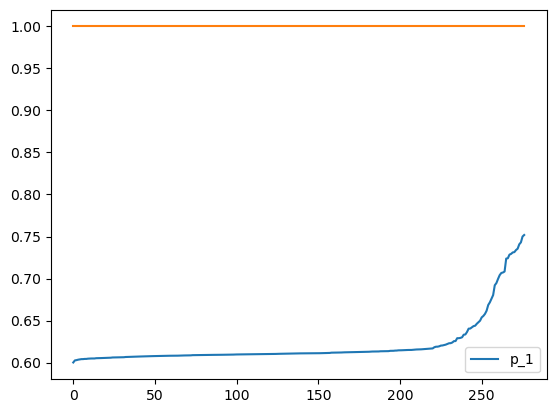

In [10]:
df.sort_values(by="p_1").reset_index().plot(y="p_1").plot(df["y_hat"])